In [2]:
import pandas as pd
import numpy as np
import os

os.environ['HF_HOME'] = '/vol/tensusers3/jdusseljee/hf_home'

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import pickle
from sklearn.metrics import roc_auc_score

In [3]:
class Paths:
  meta_data = '../datasets/addresso/train/meta_data.csv'
  transcripts = '../datasets/addresso/train/transcription/'
  concatenated = '../datasets/addresso/train/concatenated/'
  normalised = '../datasets/addresso/train/normalised/'
  text_participants = '../datasets/addresso/train/text_participants/'
  text_both = '../datasets/addresso/train/text_both/'
  whisper_transcript = '../datasets/addresso/train/whisper_transcript_text/'

class Config:
  bert_model_name = 'bert-base-uncased'
  num_classes = 2
  max_length = 512
  batch_size = 16
  num_epochs = 10
  learning_rate = 5e-5
  folds = 5
  drop_rate = .5
  weight_decay=0.1

In [4]:
train_df = pd.read_csv(Paths.meta_data)
train_df['text'] = train_df['ID'].apply(lambda x: open(Paths.whisper_transcript + x + '.txt', 'r').read())

train_df.head()

,ID,age,gender,mmse,class,text
0,S001,74,male,NaN,0,"Well, there's a mother standing there washing..."
1,S002,62,female,30.0,0,Welcome to the world of
2,S003,69,female,29.0,0,"Okay, there is a little boy, and he's standin..."
3,S004,71,female,30.0,0,"You ready? Well, the sink is overflowing. Mot..."
4,S005,74,female,30.0,0,"Alright, the mother is washing the dishes, an..."


In [5]:
class AddressoDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df['text'][idx]
        label = self.df['class'][idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
class BERTClassifier(nn.Module):
  def __init__(self, model_name, num_classes):
    super(BERTClassifier, self).__init__()

    self.bert = AutoModel.from_pretrained(model_name)
    self.dropout = nn.Dropout(Config.drop_rate)
    self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    logits = F.softmax(self.fc(x), dim=1)
    return logits

In [7]:
def train(model, data_loader, optimizer, device):
  model.train()
  for batch in tqdm(data_loader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    loss.backward()
    optimizer.step()
    # scheduler.step()

In [8]:
def evaluate(model, data_loader, device):
  model.eval()
  predictions = []
  true_labels = []
  probs = []
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids, attention_mask)
      _, preds = torch.max(outputs, dim=1)
      predictions.extend(preds.cpu())
      true_labels.extend(labels.cpu())
      probs.extend(outputs[:,1].cpu())

  return accuracy_score(true_labels, predictions), predictions, probs

In [9]:
tokenizer = AutoTokenizer.from_pretrained(Config.bert_model_name)
device = 'cuda:6'

In [10]:
skf = StratifiedKFold(n_splits=Config.folds, shuffle=True, random_state=42)

accuracies = np.empty((Config.folds, Config.num_epochs))

predictions = np.zeros((len(train_df)))
probabilities = np.zeros((len(train_df)))

pred_df = pd.DataFrame()

for fold, (train_index, test_index) in enumerate(skf.split(train_df, train_df['class'])):
  df_train, df_test = train_df.iloc[train_index].reset_index(drop=True), train_df.iloc[test_index].reset_index(drop=True)

  train_dataset = AddressoDataset(df_train, tokenizer, Config.max_length)
  test_dataset = AddressoDataset(df_test, tokenizer, Config.max_length)

  train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)

  model = BERTClassifier(Config.bert_model_name, num_classes=Config.num_classes).to(device)
  optimizer = AdamW(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
  total_steps = len(train_loader) * Config.num_epochs

  best_acc = -1
  best_preds = None

  for epoch in range(Config.num_epochs):
    train(model, train_loader, optimizer, device)
    acc, preds, probs = evaluate(model, test_loader, device)

    accuracies[fold, epoch] = acc

    if acc > best_acc:
      best_acc = acc
      predictions[test_index] = preds
      probabilities[test_index] = probs
      torch.save(model, f'best_model_fold_{fold}.pth')

pred_df.loc[:, f'pred'] = probabilities


KeyboardInterrupt: 

In [11]:
# pred_df.to_csv('pred_df_bert.csv')
pred_df = pd.read_csv('pred_df_bert.csv')

In [13]:
print(roc_auc_score(train_df['class'], pred_df['pred']))

0.7613168724279836


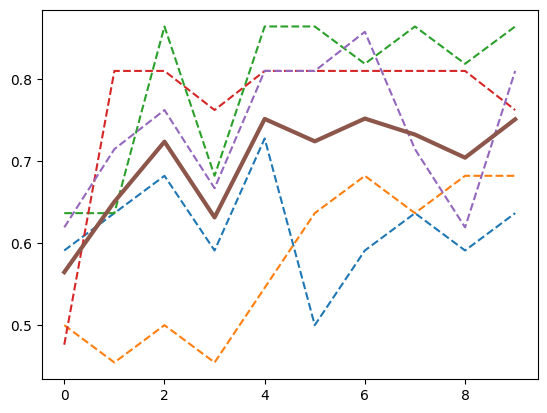

In [ ]:
for fold in range(Config.folds):
  plt.plot(accuracies[fold], linestyle='--')

plt.plot(accuracies.mean(axis=0), linewidth=3)